In [1]:
%matplotlib inline

In [19]:
from __future__ import absolute_import, division, print_function

from collections import Iterable, MutableMapping, OrderedDict
from glob import glob
from os import makedirs
from os.path import abspath, basename, expanduser, expandvars, join, isdir, isfile
import pickle
import sys
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import pandas as pd
from scipy import optimize, stats

RETRO_DIR = abspath('..')
sys.path.append(RETRO_DIR)
from retro.retro_types import FitStatus
from retro.utils.stats import weighted_percentile, fit_cdf
from retro.utils.fit_prior_dist import TRUTH_FNAME, RECOS_FNAME, RECO_PERF_FNAME, PARAMS, RECOS, extract

In [4]:
outdir = '~/extract'
outdir = expanduser(expandvars(outdir))

Note that all recos tested / extracted for this study are:

```
CascadeLast_DC DipoleFit_DC FiniteRecoFit L4_ToI L4_ToIEval2 L4_ToIEval3 L4_iLineFit L5_SPEFit11
LineFit LineFit_DC MM_DC_LineFitI_MM_DC_Pulses_1P_C05 MM_IC_LineFitI MPEFit MPEFitMuEX
PoleMuonLinefit PoleMuonLlhFit SPEFit2 SPEFit2MuEX_FSS SPEFit2_DC SPEFitSingle SPEFitSingle_DC ToI_DC
```

In [5]:
def plot_dists(reco_perf, truth, recos, outbase=None, plot_reco_names=None, params=('x', 'y', 'z', 'time'), outdir=outdir):
    xlim = dict(
        x=(-250, 250),
        y=(-250, 250),
        z=(-200, 200),
        time=(-1000, 1000),
    )

    if plot_reco_names is None:
        plot_reco_names = sorted(reco_perf.reco.unique())
    
    outdir = expanduser(expandvars(outdir))

    nr = len(plot_reco_names)
    fig, axes = plt.subplots(nr, 4, dpi=72, figsize=(20, 3*nr))
    axiter = iter(axes.flat)

    for reco_name in plot_reco_names:
        reco_vals = recos[reco_name]
        for param in params:
            try:
                err = reco_vals[param] - truth[param]
                mask = np.isfinite(err) & (reco_vals['fit_status'] == FitStatus.OK)
                valid_err = err[mask]

                ax = axiter.next()
                xl = xlim[param]
                bins = np.linspace(xl[0], xl[1], 100)
                ax.hist(valid_err, bins=bins, weights=truth['weight'][mask], density=True, label='weighted')
                ax.hist(valid_err, bins=bins, weights=None, density=True, histtype='step', label='unweighted')
                ax.set_xlim(xl)
                ax.set_yticks([])
                ax.legend(loc='upper right', frameon=False)

                info = reco_perf.query('(reco == @reco_name) & (param == @param)')
                info_d = dict(zip(info.columns, info.values[0]))
                label = '\n'.join([
                    'Invalid: {n_invalid:-5d}',
                    'Mean   : {err_mean:+8.2f}',
                    'Median : {err_median:+8.2f}',
                    'IQ50%  : {err_iq50:+8.2f}',
                    'IQ90%  : {err_iq90:+8.2f}',
                ]).format(**info_d)
                ax.add_artist(
                    AnchoredText(label, loc='center left', prop=dict(size=10, family='monospace'), frameon=False)
                )
                label = '{reco}\n{param}'.format(**info_d)
                ax.add_artist(
                    AnchoredText(label, loc='upper left', prop=dict(size=12, family='monospace', horizontalalignment='left'), frameon=False)
                )
            except:
                print('ERROR! ->', reco_name, param)
                raise
            reco_perf.append(info)

    fig.tight_layout()
    
    if outdir is not None and outbase is not None:
        fbase = join(outdir, outbase)
        fig.savefig(fbase + '.png', dpi=120)
        fig.savefig(fbase + '.pdf')

    return axes

In [6]:
%%time

try:
    truth = pickle.load(open(join(outdir, TRUTH_FNAME), 'rb'))
    recos = pickle.load(open(join(outdir, RECOS_FNAME), 'rb'))
    reco_perf = pickle.load(open(join(outdir, RECO_PERF_FNAME), 'rb'))
except:
    reco_perf, recos, truth = extract(outdir=outdir)

CPU times: user 0 ns, sys: 264 ms, total: 264 ms
Wall time: 268 ms


In [7]:
reco_perf.head(12)

,reco,param,n_invalid,err_mean,err_median,err_min,err_max,err_iq50,err_iq90,err_absmean,err_absmedian,err_absmin,err_absmax
3,CascadeLast_DC,time,0,-155.880014,-48.012947,-9484.270046,3876.533545,238.115281,1263.376408,155.880014,48.012947,9484.270046,3876.533545
0,CascadeLast_DC,x,0,0.604676,0.296250,-830.908354,744.155523,48.882027,165.793830,0.604676,0.296250,830.908354,744.155523
1,CascadeLast_DC,y,0,-1.391772,-0.872808,-790.823059,732.180057,49.123325,164.602762,1.391772,0.872808,790.823059,732.180057
2,CascadeLast_DC,z,0,21.346728,12.963239,-451.939152,941.441388,35.555734,135.171505,21.346728,12.963239,451.939152,941.441388
7,DipoleFit_DC,time,8223,667.061394,621.691201,-1237.110867,3883.161129,385.844602,1002.953604,667.061394,621.691201,1237.110867,3883.161129
4,DipoleFit_DC,x,8223,0.803873,0.410057,-787.704267,742.925840,54.121427,171.121822,0.803873,0.410057,787.704267,742.925840
5,DipoleFit_DC,y,8223,-1.749155,-1.276294,-717.586528,706.941344,53.580603,169.571827,1.749155,1.276294,717.586528,706.941344
6,DipoleFit_DC,z,8223,22.695088,15.229438,-447.082036,814.142432,40.457024,139.362137,22.695088,15.229438,447.082036,814.142432
11,L4_ToIEval2,time,0,612.447487,560.909701,-2143.376968,5350.260675,404.275206,1048.665015,612.447487,560.909701,2143.376968,5350.260675
8,L4_ToIEval2,x,0,0.604676,0.296250,-830.908354,744.155523,48.882027,165.793830,0.604676,0.296250,830.908354,744.155523


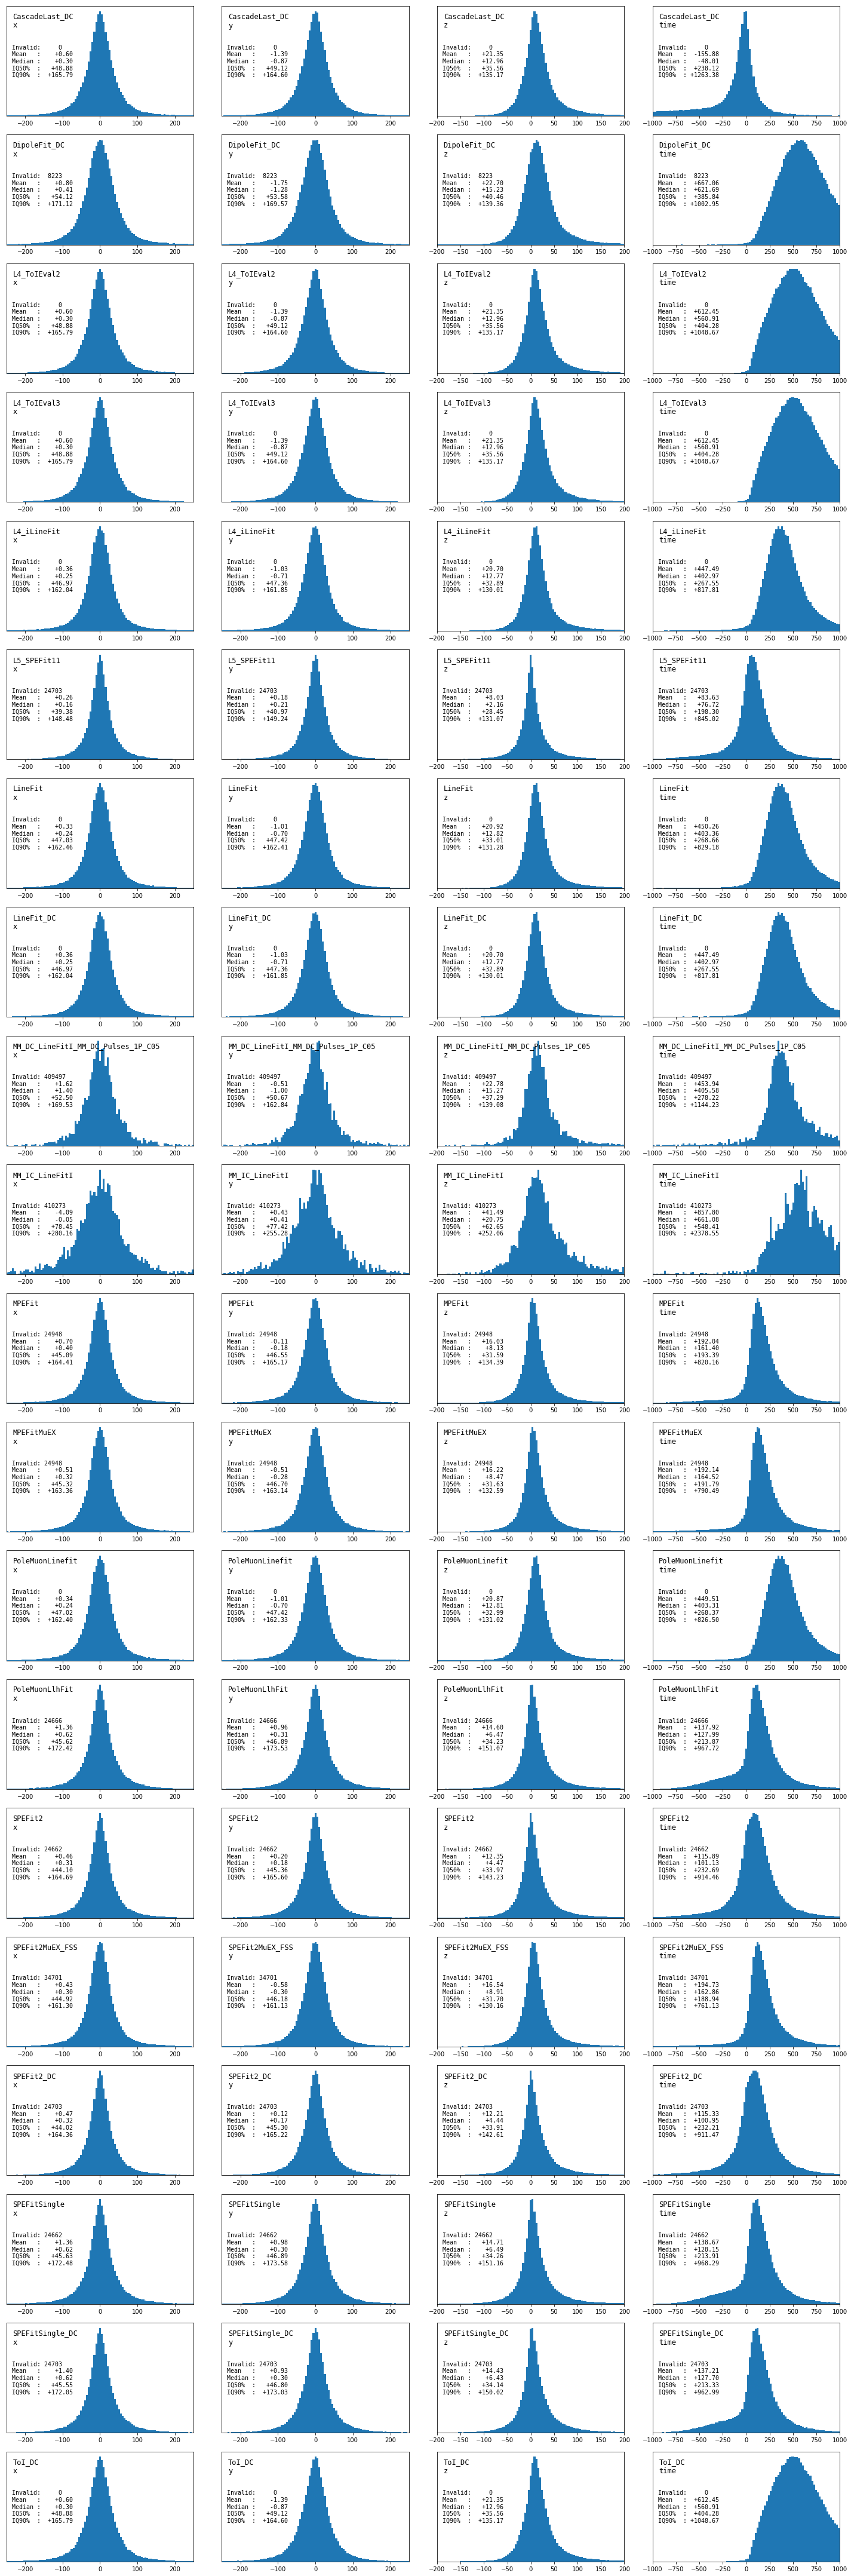

In [42]:
ax = plot_dists(reco_perf=reco_perf, truth=truth, recos=recos, outdir=datadir, outbase='err_dist_by_reco')

In [8]:
medians = reco_perf.groupby('param').quantile(0.5)
medians

0.5,err_absmax,err_absmean,err_absmedian,err_absmin,err_iq50,err_iq90,err_max,err_mean,err_median,err_min,n_invalid
param,,,,,,,,,,,
time,6702.637254,321.111473,283.746720,3329.264270,252.832335,938.726180,6702.637254,321.111473,283.746720,-3329.264270,24662.0
x,762.277221,0.604676,0.297601,875.081663,46.973865,165.240249,762.277221,0.557513,0.297601,-875.081663,24662.0
y,789.750054,0.971089,0.555058,796.003029,47.357383,164.602762,789.750054,-0.547327,-0.503559,-796.003029,24662.0
z,959.207703,20.696406,12.772875,451.939152,34.052265,135.171505,959.207703,20.696406,12.772875,-451.939152,24662.0


no invalid reos: ['CascadeLast_DC', 'L4_ToIEval2', 'L4_ToIEval3', 'L4_iLineFit', 'LineFit', 'LineFit_DC', 'PoleMuonLinefit', 'ToI_DC']
best recos by ['err_iq50', 'err_iq90']: ['L5_SPEFit11', 'MPEFitMuEX', 'SPEFit2MuEX_FSS']
both good fits and no invalid: set([])
best no-invlid reccos by ['err_iq50', 'err_iq90']: ['L4_iLineFit', 'LineFit_DC', 'PoleMuonLinefit']
recos to compare: ['L5_SPEFit11', 'MPEFitMuEX', 'SPEFit2MuEX_FSS', 'L4_iLineFit', 'LineFit_DC', 'PoleMuonLinefit']


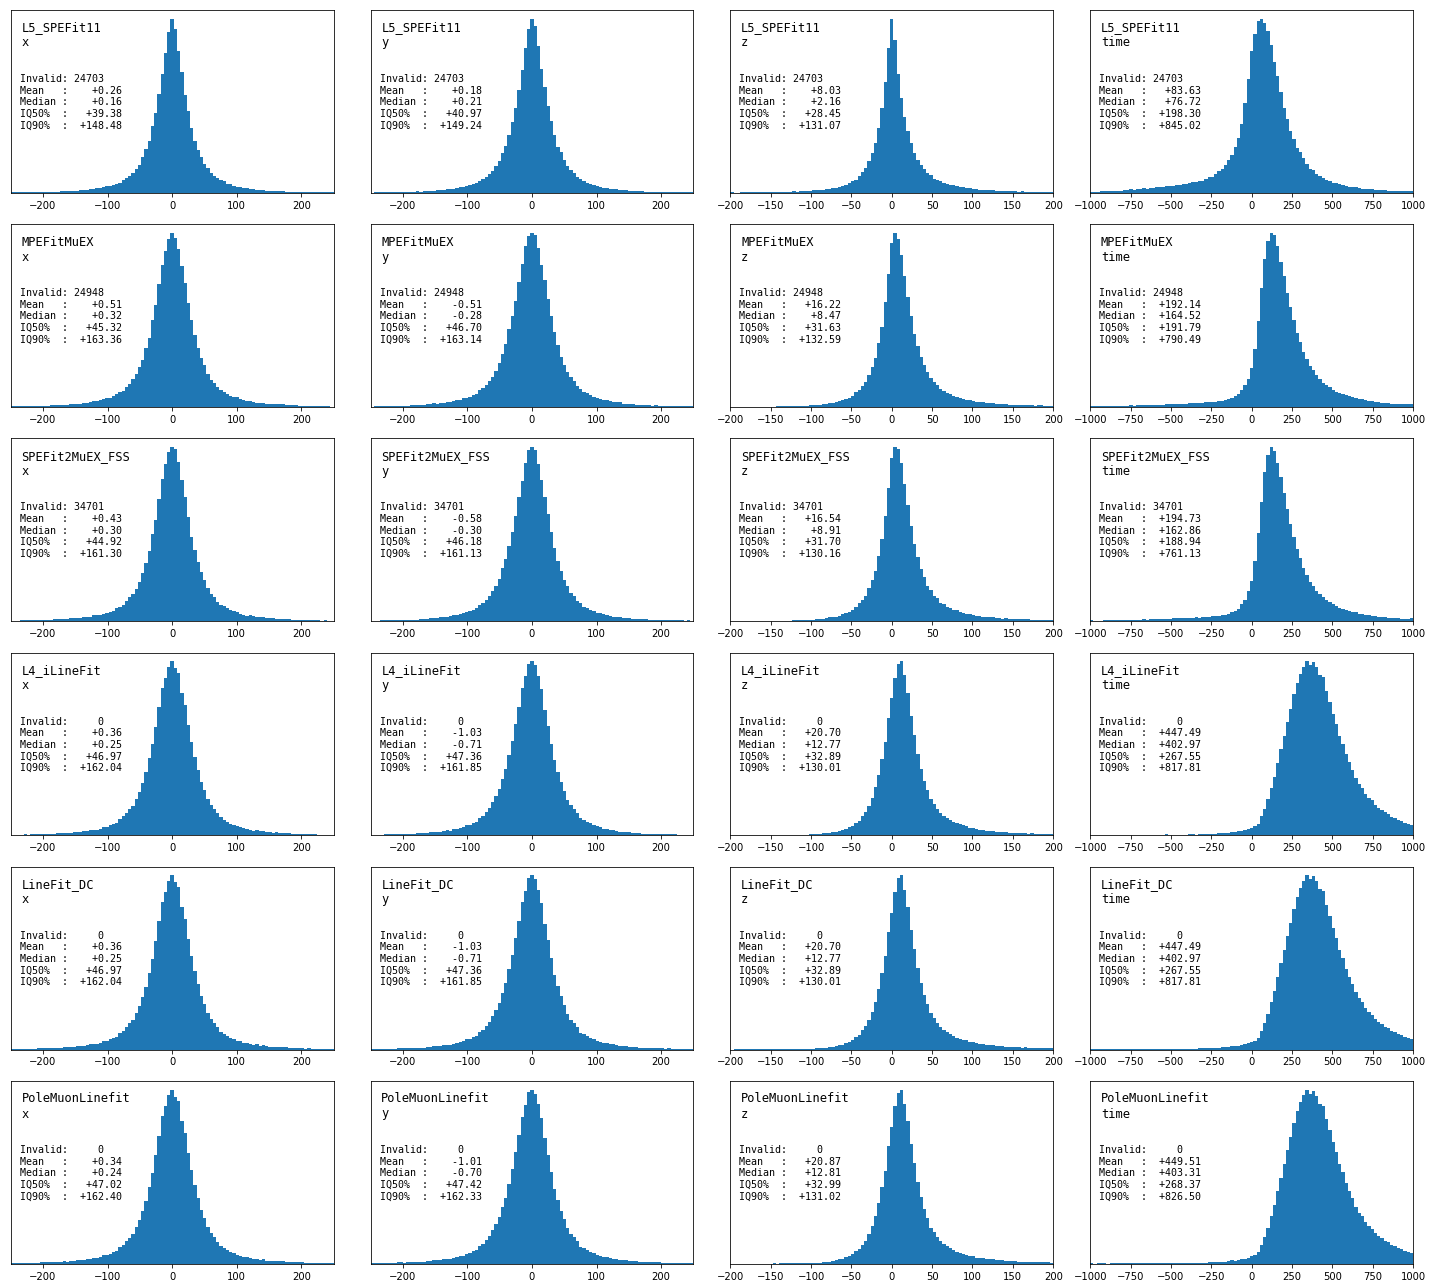

In [46]:
medians = reco_perf.groupby('param').quantile(0.5)

bad_fits = set()
no_invalid = set()
param_names = medians.index.values
compare_cols = ['err_iq50', 'err_iq90']
for idx, grp in reco_perf.groupby('reco'):
    include = True
    for param in param_names:
        if np.all(grp['n_invalid'] == 0):
            no_invalid.add(idx)
        if np.sum(grp.query('param == @param')[compare_cols].values > medians.loc[param][compare_cols].values) > 0:
            bad_fits.add(idx)
best = set([r for r in RECOS if r not in bad_fits])
best_and_no_invalid = best.intersection(no_invalid)
print('no invalid reos:', sorted(no_invalid))
print('best recos by {}: {}'.format(compare_cols, sorted(best)))
print('both good fits and no invalid: {}'.format(best_and_no_invalid))


infos_no_invalid = reco_perf.query('reco in @no_invalid')
medians_no_invalid = infos_no_invalid.groupby('param').quantile(0.5)
bad_fits_no_invalid = set()
param_names = medians_no_invalid.index.values
compare_cols = ['err_iq50', 'err_iq90']
for idx, grp in infos_no_invalid.groupby('reco'):
    for param in param_names:
        if np.sum(grp.query('param == @param')[compare_cols].values > medians_no_invalid.loc[param][compare_cols].values) > 0:
            bad_fits_no_invalid.add(idx)
best_of_no_invalid = set([r for r in infos_no_invalid['reco'].unique() if r not in bad_fits_no_invalid])
print('best no-invlid reccos by {}: {}'.format(compare_cols, sorted(best_of_no_invalid)))

remaining = sorted(best) + sorted([r for r in best_of_no_invalid if r not in best])
print('recos to compare:', remaining)

ax = plot_dists(reco_perf=reco_perf, truth=truth, recos=recos, plot_reco_names=remaining, outbase='err_dist_by_reco_best')

In [9]:
failed_spe11 = recos['L5_SPEFit11']['fit_status'] != FitStatus.OK
failed_spemuex = recos['SPEFit2MuEX_FSS']['fit_status'] != FitStatus.OK

In [10]:
print(np.sum(failed_spe11), np.sum(failed_spemuex))
print(np.sum(failed_spe11 == failed_spemuex), np.sum(failed_spe11 != failed_spemuex))
print(np.sum(failed_spe11 & np.logical_not(failed_spemuex)))
print(np.sum(failed_spemuex & np.logical_not(failed_spe11)))

24703 34701
405160 10102
52
10050


Based on the above, we will choose to use **L5_SPEFit11** for first shot and if that is a failed reco, fall back on **LineFit_DC**.

In [11]:
CHOSEN_RECOS = ('L5_SPEFit11', 'LineFit_DC')

/home/justin/anaconda2/lib/python2.7/site-packages/matplotlib/offsetbox.py:1259: UserWarning: Mixing horizontalalignment or verticalalignment with AnchoredText is not supported.
  warnings.warn("Mixing horizontalalignment or verticalalignment "


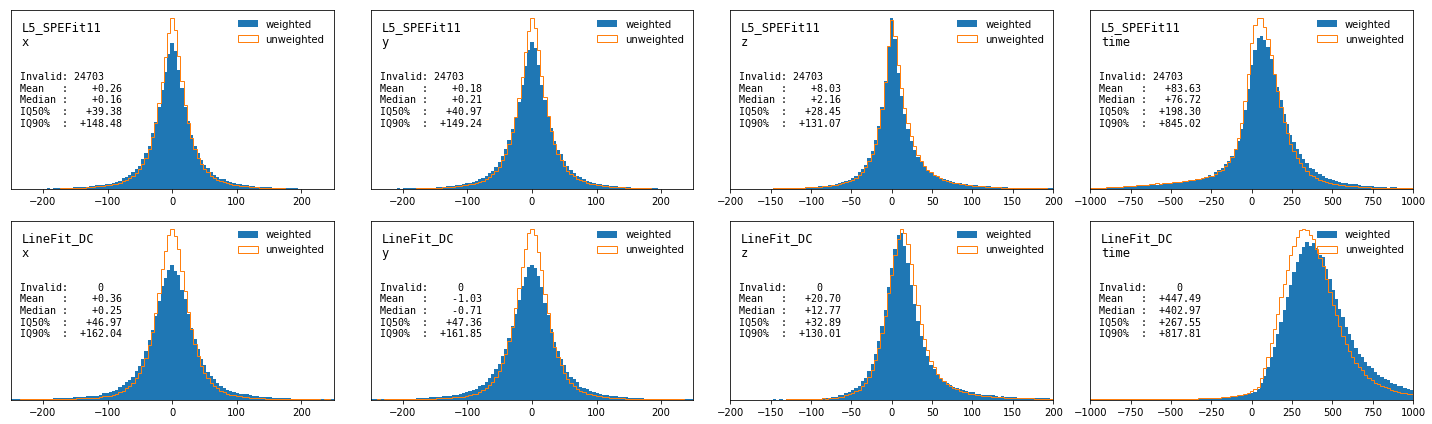

In [12]:
axes = plot_dists(reco_perf=reco_perf, truth=truth, recos=recos, plot_reco_names=CHOSEN_RECOS, outbase='err_dist_by_reco_chosen')

# Fitting the distributions

In [14]:
ls ~/extract/*pkl

/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time__dists_sha256=44fcc6564d.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=56519c0fdd.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=63e9fcd035.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=9b33da3caf.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=c48e7eef1e.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=time,x,y,z__dists_sha256=e3b98a4da3.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=x__dists_sha256=27368d421f0ff4d182b62a7a46b98f76a2bcf8f1ced2da0d8ac8997145b94342.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=x__dists_sha256=44fcc6564d.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=x__dists_sha256=63e9fcd035.pkl
/home/justin/extract/fit_info__reco=L5_SPEFit11__params=x__dists_sha256=e3b98a4da3.pkl
/home/justin/extract/fit_inf

In [16]:
dists_sha256 = '44fcc6564d'
all_recos_fits = OrderedDict()
for reco in CHOSEN_RECOS:
    reco_fits = {}
    for f in glob(join(outdir, 'fit_info__reco={}__*__dists_sha256={}.pkl'.format(reco, dists_sha256))):
        tmp = pickle.load(open(f, 'rb'))
        reco_fits.update(tmp)

    tmp = OrderedDict()
    for k in sorted(reco_fits.keys()):
        tmp[k] = reco_fits[k]
    reco_fits = tmp

    all_recos_fits[reco] = reco_fits

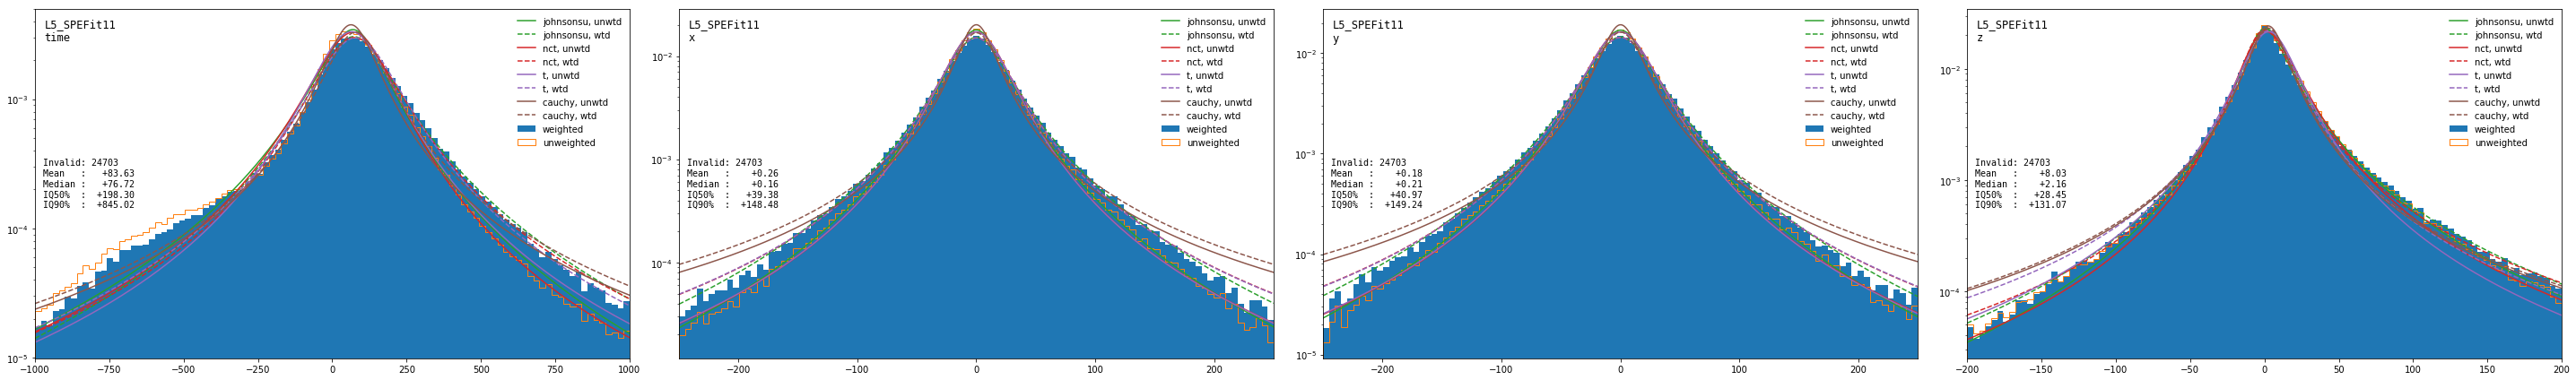

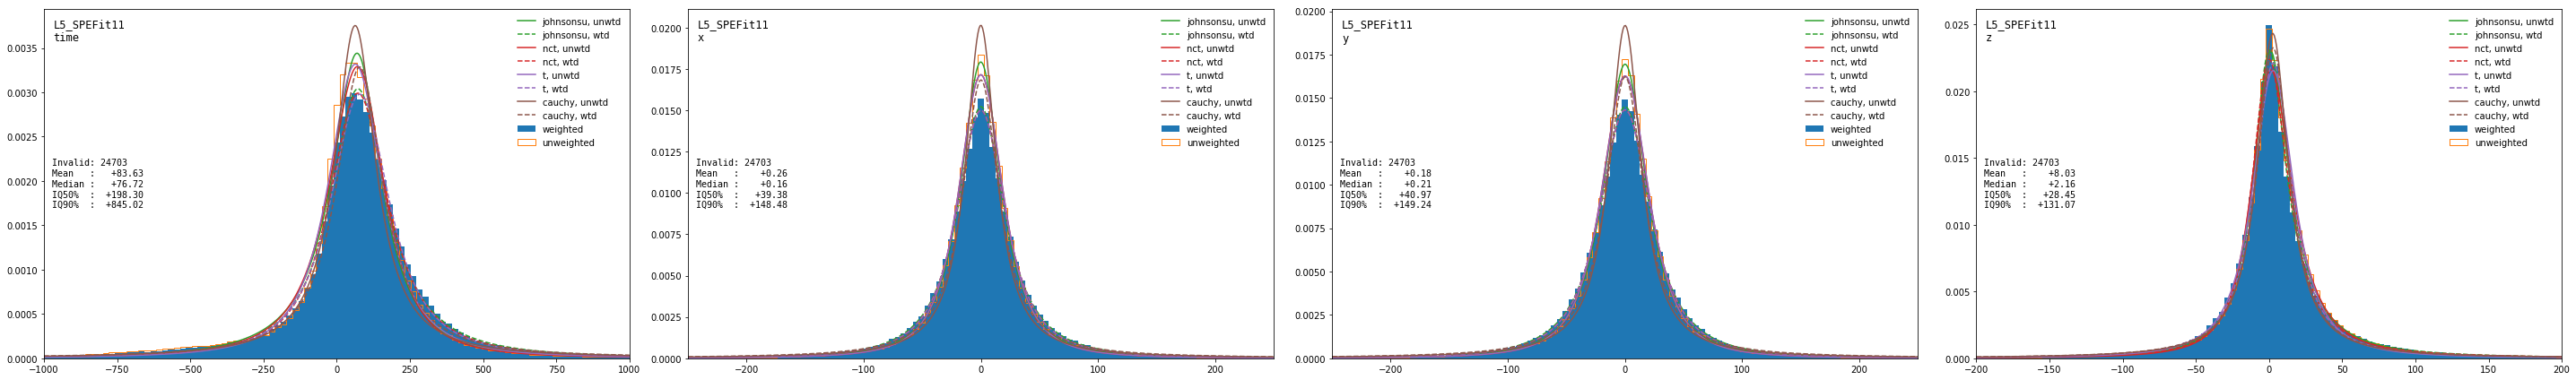

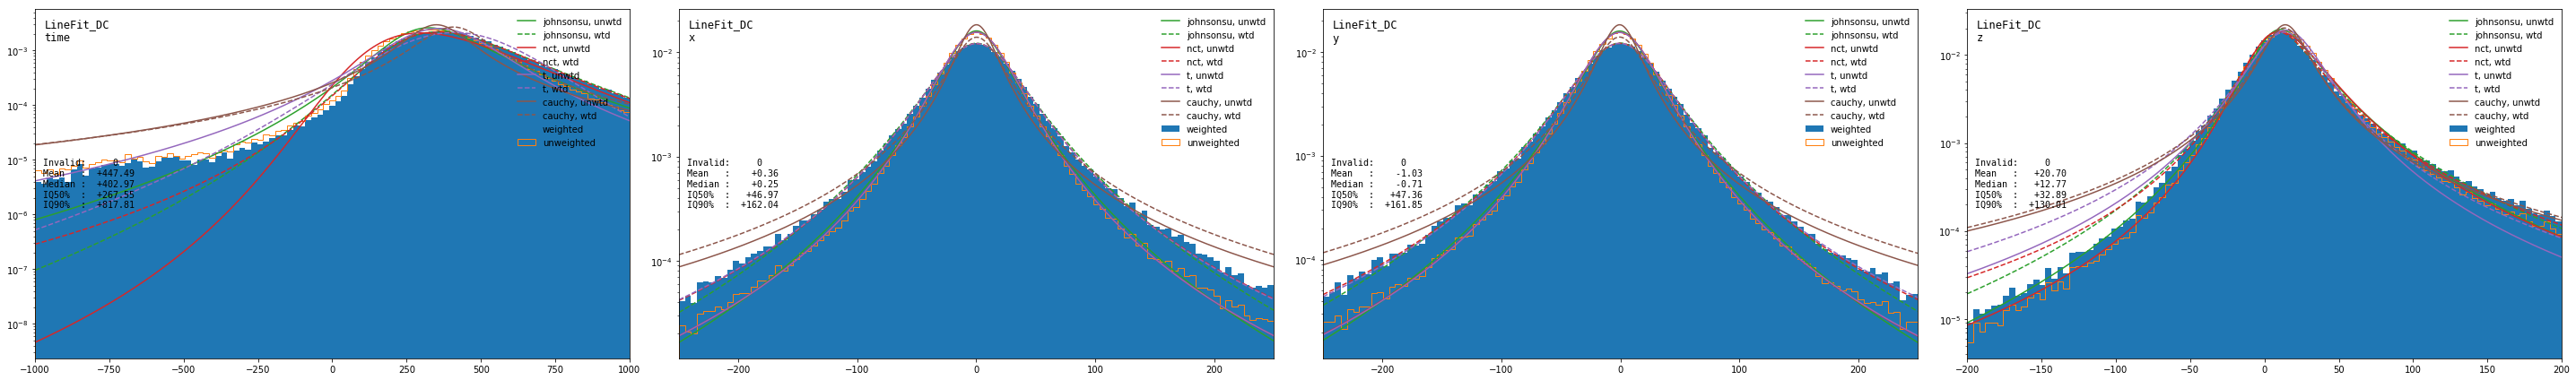

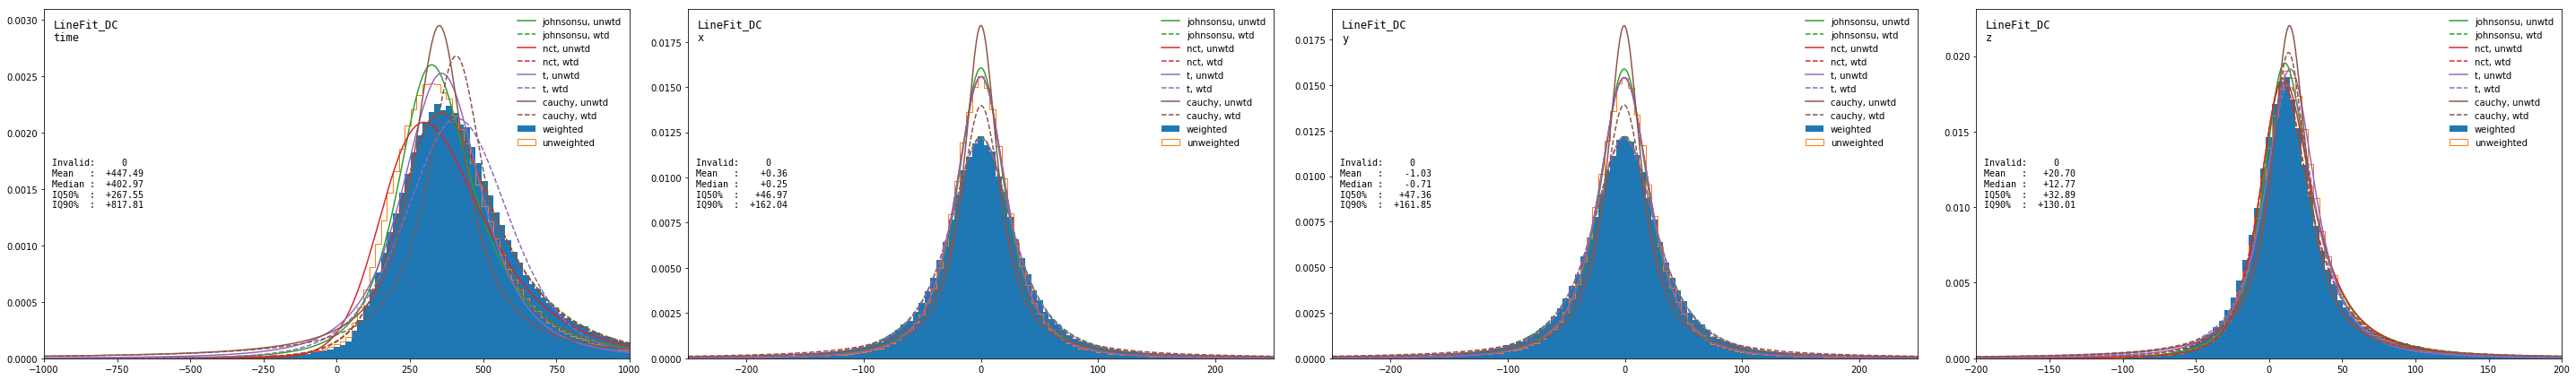

In [98]:
for reco, reco_fits in all_recos_fits.items():
    for yscale in ['log', 'linear']:
        n_params = len(reco_fits)
        axes = plot_dists(reco_perf=reco_perf, truth=truth, recos=recos, plot_reco_names=[reco], params=reco_fits.keys())
        axit = iter(axes)
        for ax, (param, dist_fits) in zip(axes, reco_fits.items()):
            ax.set_yscale(yscale)
            for dist_name, fits in dist_fits.items():
                xlim = ax.get_xlim()
                x = np.linspace(xlim[0], xlim[1], 500)
                dist = getattr(stats.distributions, dist_name)
                pdf_unwtd = dist.pdf(x, **fits['first_guess_params'])
                pdf_wtd = dist.pdf(x, **fits['best_fit_params'])
                lines = ax.plot(x, pdf_unwtd, label='{}, unwtd'.format(dist_name))
                color = lines[0].get_color()
                ax.plot(x, pdf_wtd, label='{}, wtd'.format(dist_name), color=color, ls='--')
                ax.legend(loc='upper right', frameon=False, )
        fig = ax.get_figure()
        fig.set_figheight(fig.get_figheight()*2)
        fig.set_figwidth(fig.get_figwidth()*2)
        fig.tight_layout()
        basefpath = join(outdir, 'plot_dist_fits_{}_{}'.format(reco, yscale))
        fig.savefig(basefpath + '.pdf')
        fig.savefig(basefpath + '.png', dpi=120)

Based on the above, we are choosing:

**L5_SPEFit11**
* time : t wtd
* x : t wtd
* y : t wtd
* z : johnsonsu wtd

**LineFit_DC**
* time : cauchy wtd
* x : t wtd
* y : t wtd
* z : johnsonsu wtd

In [21]:
CHOSEN_DISTS = OrderedDict()

CHOSEN_DISTS['L5_SPEFit11'] = OrderedDict([('time', 't wtd'), ('x', 't wtd'), ('y', 't wtd'), ('z', 'johnsonsu wtd')])
CHOSEN_DISTS['LineFit_DC'] = OrderedDict([('time', 'cauchy wtd'), ('x', 't wtd'), ('y', 't wtd'), ('z', 'johnsonsu wtd')])
CHOSEN_DISTS

OrderedDict([('L5_SPEFit11',
              OrderedDict([('time', 't wtd'),
                           ('x', 't wtd'),
                           ('y', 't wtd'),
                           ('z', 'johnsonsu wtd')])),
             ('LineFit_DC',
              OrderedDict([('time', 'cauchy wtd'),
                           ('x', 't wtd'),
                           ('y', 't wtd'),
                           ('z', 'johnsonsu wtd')]))])

In [26]:
priors = OrderedDict()

for reco in CHOSEN_RECOS:
    for param in PARAMS:
        dist_name, wtd_or_not = CHOSEN_DISTS[reco][param].split()
        if wtd_or_not == 'wtd':
            pfx = 'best_fit'
        elif wtd_or_not == 'unwtd':
            pfx = 'first_guess'
        else:
            raise ValueError(str(wtd_or_not))
        print(reco, param)
        print('dist = "{}"'.format(dist_name))
        print('params =', all_recos_fits[reco][param][dist_name]['{}_params'.format(pfx)])
        print('')

L5_SPEFit11 x
dist = "t"
params = OrderedDict([('df', 1.6867177062057637), ('loc', 0.14572812956903736), ('scale', 23.08818410937512)])

L5_SPEFit11 y
dist = "t"
params = OrderedDict([('df', 1.789131128595108), ('loc', 0.15629563873773936), ('scale', 24.36539086049123)])

L5_SPEFit11 z
dist = "johnsonsu"
params = OrderedDict([('a', -0.17359502368500432), ('b', 0.669853628005461), ('loc', -0.7080854707830284), ('scale', 11.44815037261141)])

L5_SPEFit11 time
dist = "t"
params = OrderedDict([('df', 1.5377646263557783), ('loc', 79.0453249765558), ('scale', 114.79326906544053)])

LineFit_DC x
dist = "t"
params = OrderedDict([('df', 2.2190042841052935), ('loc', 0.29762236741186276), ('scale', 29.41702014032123)])

LineFit_DC y
dist = "t"
params = OrderedDict([('df', 2.2072136793550525), ('loc', -0.7624014993241222), ('scale', 29.541536688919628)])

LineFit_DC z
dist = "johnsonsu"
params = OrderedDict([('a', -0.27708333289811304), ('b', 0.8677377365398546), ('loc', 6.722685934950411), ('scal